# Compare the free energy by direct versus indirect minimisation
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
In this notebook I will apply the schematic from the 'Essentials.ipynb' and 'Minimisation_F.ipynb' files to compute the min_energy, max_entropy and free_energy from the dataset. I compare the direct versus indirect minimisation of free energy, i.e. min[F(p)] versus min[U(p)] - T*max[S(p)].

In [2]:
# Import necessary libraries
import numpy as np
import glob

# Import external background functions
%run background_functions.py

In [3]:
# Import HCP data
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

In [4]:
# Define desired settings
cutoff=0.8 # Value between 0 and 1. Values below this value are set to zero. Becomes obsolete after including phase randomisation
max_dim=4

In [7]:
euler_characteristic, clique_complex = compute_euler(matrices[0],cutoff,max_dim)
inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

Compare optimisation parameters for one subject

In [12]:
# Example for generating energy and entropy data from a given matrix
list_size = len(inverse_connectivity_matrix)
num_iterations_free_energy = 100
num_iterations_energy = 20000
num_iterations_entropy = 1000
sampling_distributions = ['uniform', 'normal', 'chisquare', 'gamma', 'pareto', 'lognormal']
free_energy_probabilities = []
energy_probabilities = []
entropy_probabilities = []

for _ in sampling_distributions:
    initial_probabilities = generate_probability_list(list_size, _)
    # Minimum helmholtz free energy
    free_energy_history, current_probabilities_energy = simulated_annealing_free_energy(initial_probabilities, _, -0.1, inverse_connectivity_matrix, num_iterations_free_energy, initial_temperature=1.0, cooling_rate=0.95)
    # Minimum internal energy
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, _ , -0.1, inverse_connectivity_matrix, num_iterations_energy)
    # Maximum shannon entropy
    entropy_history, current_probabilities_entropy = simulated_annealing_entropy(initial_probabilities, _ , -0.1, num_iterations_entropy)

    # Store probabilities type
    free_energy_probabilities.append(free_energy_history)
    energy_probabilities.append(energy_history)
    entropy_probabilities.append(entropy_history)

C:\Users\cyril\Documents\GitHub\Free_energy_of_simplicial_complexes\background_functions.py:41: RuntimeWarning: overflow encountered in scalar divide
  if new_value < current_value or np.random.rand() < np.exp((current_value - new_value) / temperature):
C:\Users\cyril\Documents\GitHub\Free_energy_of_simplicial_complexes\background_functions.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  if new_value < current_value or np.random.rand() < np.exp((current_value - new_value) / temperature):


In [13]:
# Maximum shannon entropy from uniform distribution
n = len(inverse_connectivity_matrix)
p_Smax = np.ones(n) / n
max_entropy_value = shannon_entropy(p_Smax)
max_entropy = [max_entropy_value]*num_iterations_entropy

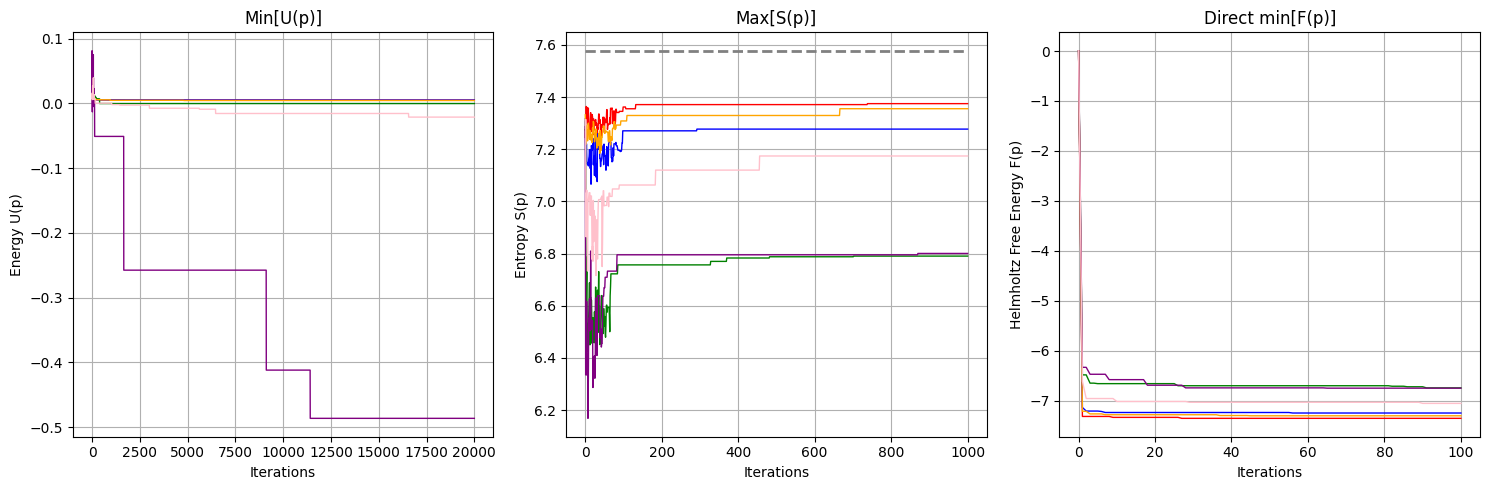

In [16]:
# Plotting the optimisation side by side
plt.figure(figsize=(15, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 3, 1)
for i in range(len(sampling_distributions)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Min[U(p)]')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
#plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(max_entropy, color='grey', linestyle='--', linewidth = 2, label='S for uniform p')
for i in range(len(sampling_distributions)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Max[S(p)]')
plt.xlabel('Iterations')
plt.ylabel('Entropy S(p)')
#plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
for i in range(len(sampling_distributions)):
    plt.plot(free_energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'p sampled from {sampling_distributions[i]}')
plt.title('Direct min[F(p)]')
plt.xlabel('Iterations')
plt.ylabel('Helmholtz Free Energy F(p)')
#plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

For internal energy minimisation pareto seems the best. Test parameters to find the best settings. For the entropy and free energy the uniform distribution are the best, so no additional settings are required. Notice that the free energy minimisation seems to converge much quicker than the other functionals.

In [17]:
# Example for generating energy and entropy data from a given matrix
list_size = len(inverse_connectivity_matrix)
num_iterations_energy = 5000
num_iterations_entropy = 5000
energy_probabilities = []
entropy_probabilities = []
pareto_constants = [-0.1, -0.3, -0.6, -0.9]
cooling_rates = [0.99, 0.9, 0.6, 0.3, 0.1]

for pareto_constant in pareto_constants:
    initial_probabilities = generate_probability_list(list_size, 'genpareto')
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, 'genpareto' , pareto_constant, inverse_connectivity_matrix, num_iterations_energy)
    # Store probabilities type
    energy_probabilities.append(energy_history)

for current_cooling_rate in cooling_rates:
    initial_probabilities = generate_probability_list(list_size, 'genpareto')
    # Minimum internal energy with simulated annealing
    energy_history, current_probabilities_energy = simulated_annealing_energy(initial_probabilities, 'genpareto' , -0.1, inverse_connectivity_matrix, num_iterations_energy, cooling_rate=current_cooling_rate)
    # Store probabilities type
    entropy_probabilities.append(energy_history)

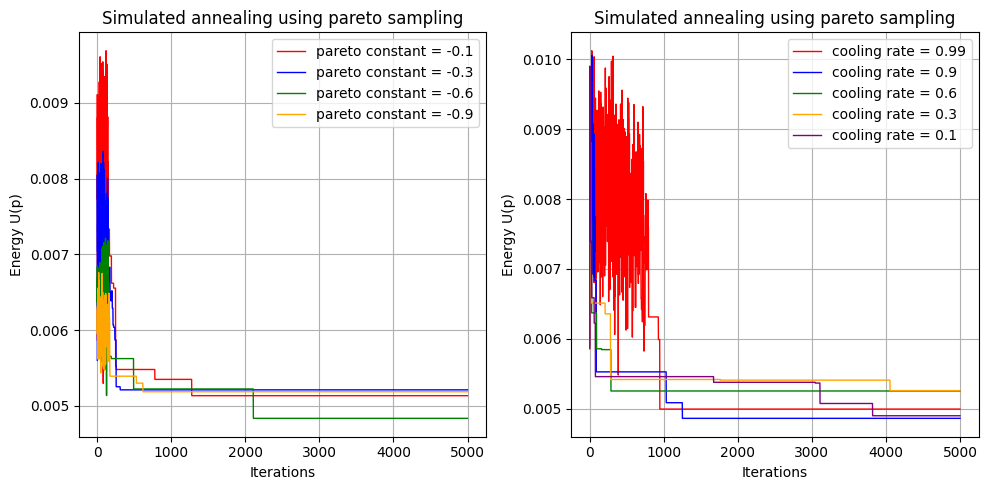

In [18]:
# Plotting the optimisation side by side
plt.figure(figsize=(10, 5))
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot the energy/entropy evolution against the number of Simulated Annealing iterations

plt.subplot(1, 2, 1)
for i in range(len(pareto_constants)):
    plt.plot(energy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'pareto constant = {pareto_constants[i]}')
plt.title('Simulated annealing using pareto sampling')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(len(cooling_rates)):
    plt.plot(entropy_probabilities[i], color=colors[i], linestyle='-', linewidth=1, label = f'cooling rate = {cooling_rates[i]}')
plt.title('Simulated annealing using pareto sampling')
plt.xlabel('Iterations')
plt.ylabel('Energy U(p)')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Generate free energy from direct versus indirect minimisation for all subjects

In [19]:
free_energy_direct = []
free_energy_indirect = []

for matrix in matrices:
    free_energy_subject_1 = computing_functionals_direct(matrix, cutoff, max_dim)
    free_energy_direct.append(free_energy_subject_1)
    U_min, p_Umin, S_max, p_Smax, free_energy_subject_2 = computing_functionals(matrix,cutoff,max_dim)
    free_energy_indirect.append(free_energy_subject_2)

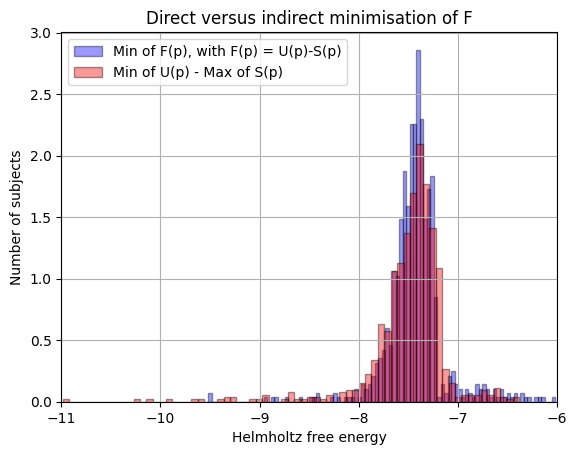

In [22]:
plt.hist(free_energy_direct, bins=100, density=True, alpha=0.4, color='blue', edgecolor='black', label= 'Min of F(p), with F(p) = U(p)-S(p)')
plt.hist(free_energy_indirect, bins=100, density=True, alpha=0.4, color='red', edgecolor='black', label = 'Min of U(p) - Max of S(p)')
plt.xlim(-11, -6)
plt.grid(True)
plt.title('Direct versus indirect minimisation of F')
plt.ylabel('Number of subjects')
plt.xlabel('Helmholtz free energy')
plt.legend()
plt.show()

Why does the direct method converge so much faster (almost instanteneously) compared to the indirect method? And if the direct method is truly close to the minimal free energy, why is there no convergence between distribution types?